In [2]:
import aplpy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import astropy.table as Table
from astropy.io import ascii
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size':12})

## LOS Velocity

In [3]:
def losVel(func, lam, apCen):
    return (func(apCen)-lam)/func(apCen) * 3e5

## Graphing Peaks

In [4]:
def addPeak(apCent,peak,figname,offset,right=False,col='r',fontcol='w'):
    if right:
        sign=1
        align='left'
    elif not right:
        sign=-1
        align='right'

    figname.add_label(peak+3*sign,apCent+offset,r'$\lambda = %s \AA$'%peak,horizontalalignment=align,color=fontcol)
    return

## Interpolation

In [5]:
def genInterp(galData):
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    fg = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind,fill_value='extrapolate')
    fm = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind,fill_value='extrapolate')
    
    return fg, fm

## Polynomial Fit

In [6]:
def genPoly(galData):
    zG = np.polyfit(galData['Aperture Center'],galData['Peak (Gaussian)'],3)
    zM = np.polyfit(galData['Aperture Center'],galData['Peak (Maximum)'],3)
    
    pG = np.poly1d(zG)
    pM = np.poly1d(zM)
    
    return pG, pM

In [7]:
def polystr(k):
    string = ''
    for i in range(len(k)):
        if i < len(k) - 1:
            string += '%.3f x^'%(k[i]) + str(len(k)-i-1) + ' + '
        else:
            string += '%.3f'%(k[i])
    return string

## Plot FITS

In [8]:
def subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,multi,sub=1,BR='B',num='1'):
    filepath = 'SN_Images/%s/%s_0%s_%s.fits'%(name,name,num,BR)
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center']),1)
    
    if multi:
        tname=name+"_0"+num
    elif not multi:
        tname=name
    
    if sub == 1:
        subCoords = [0.05,0.05,0.425,0.9]
        titleType = 'Gaussian'
#         f = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind)
        f = genPoly(galData)[0]
        fArr = np.vstack((f(apSpace),apSpace+offset))
        conLam = 'Peak (Gaussian)'
    elif sub == 2:
        subCoords = [0.55,0.05,0.425,0.9]
        titleType = 'Maximum'
#         f = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind)
        f = genPoly(galData)[1]
        fArr = np.vstack((f(apSpace),apSpace+offset))
        conLam = 'Peak (Maximum)'
    
    subplt = aplpy.FITSFigure(filepath,figure=fig,subplot=subCoords)
    subplt.recenter(centerCoord[0],centerCoord[1],width=w,height=h)
    subplt.show_grayscale(stretch='power',pmax=maxP)
    subplt.set_title('%s - %s - %.2f km/s Offset'%(tname,titleType,losVel(f,conData[conLam],conData['Aperture Center'])))
    subplt.axis_labels.set_xtext(r'Peak H$\alpha$ Wavelength ($\AA$)')
    subplt.axis_labels.set_ytext('Aperture Center (pix)')
    
    subplt.show_markers(fArr[0,:],fArr[1,:],marker='.',edgecolor='orange')
    
    for line in galData:
        addPeak(line['Aperture Center'],line[conLam],subplt,offset)
    
    addPeak(conData['Aperture Center'],conData[conLam],subplt,offset,col='k',fontcol='k')
    
    subplt.show_markers(galData[conLam],galData['Adjusted Aperture'],marker='o',s=50,edgecolor=None,facecolor='r')
    subplt.show_markers(conData[conLam],conData['Adjusted Aperture'],marker='*',s=150,edgecolor=None,facecolor='r')
    
    return



def pltFITS(name,centerCoord,offset,maxP=99,w=25,h=160,BR='B',num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))

    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))

    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    fig = plt.figure(figsize=(15,9))
    
    subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,multi,sub=1,BR=BR,num=num)
    subpltFITS(fig,name,centerCoord,offset,galData,conData,kind,maxP,w,h,multi,sub=2,BR=BR,num=num)
    
    if multi:
        fig.savefig('SN_Images/%s/%s_0%s.png'%(name,name,num))
    elif not multi:    
        fig.savefig('SN_Images/%s/%s.png'%(name,name))
    fig.show()
    return

## Plot Interpolations

In [9]:
def pltInterp(name,offset,num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    fg = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind,fill_value='extrapolate')
#     fgArr = np.vstack((fg(apSpace),apSpace+offset))
    fm = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind,fill_value='extrapolate')
#     fmArr = np.vstack((fm(apSpace),apSpace+offset))
    
    fig = plt.figure(figsize=(15,7))
    
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(tname,losVel(fg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.ylabel('Aperture Center (px)')
    plt.xlabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'])
    plt.plot(fg(apSpace),apSpace,'--',label='Interpolation')
    plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],label=name)
    plt.scatter(fg(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),
                float(max(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum - %.2f km/s Offset'%(tname,losVel(fm,conData['Peak (Maximum)'],conData['Aperture Center'])))
    plt.xlabel('Aperture Center (px)')
    plt.ylabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'])
    plt.plot(fm(apSpace),apSpace,'--',label='Interpolation')
    plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],label=name)
    plt.scatter(fm(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),
                float(max(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_interp.png'%(name,name,num))
    elif not multi:
        plt.savefig('SN_Images/%s/%s_interp.png'%(name,name))

## Plot Polynomial Fit

In [10]:
def pltPoly(name,offset,num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    
    pg, pm = genPoly(galData)
    
    fig = plt.figure(figsize=(15,7))
    
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(tname,losVel(pg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.ylabel('Aperture Center (px)')
    plt.xlabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'])
    plt.plot(pg(apSpace),apSpace,'--',label='Polynomial Fit')
    plt.scatter(pg(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],label=name)
    plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],pg(conData['Aperture Center']))),
                float(max(conData['Peak (Gaussian)'],pg(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum - %.2f km/s Offset'%(tname,losVel(pm,conData['Peak (Maximum)'],conData['Aperture Center'])))
    plt.xlabel('Aperture Center (px)')
    plt.ylabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'])
    plt.plot(pm(apSpace),apSpace,'--',label='Polynomial Fit')
    plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],label=name)
    plt.scatter(pm(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
    plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],pm(conData['Aperture Center']))),
                float(max(conData['Peak (Maximum)'],pm(conData['Aperture Center']))),50),
                [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_poly.png'%(name,name,num))
    elif not multi:
        plt.savefig('SN_Images/%s/%s_poly.png'%(name,name))

## Plot Spectrum

In [11]:
def pltSpec(name,BR='B',num='1',multi=False,winWidth=50):
    from astropy.io import fits
    
    FITSfile = fits.open('SN_Images/%s/s%s_0%s_%s_c.ms.fits'%(name,name,num,BR))
    head = FITSfile[0].header
    data = FITSfile[0].data
    
    x0 = head['CRVAL1']
    dx = head['CD1_1']
    xL = head['NAXIS1']
    
    if BR == 'B':
        maxF = max(data[-2000:])
    elif BR == 'R':
        maxF = max(data[:-2000])
    
    lamRange = np.arange(x0,dx*xL+x0,dx)[:xL]
    
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
        
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center']
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    fg, fm = genInterp(galData)
    pg, pm = genPoly(galData)
    
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian - %.2f km/s Offset'%(tname,losVel(pg,conData['Peak (Gaussian)'],conData['Aperture Center'])))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    plt.ylim(0,maxF*1.1)
    
    plt.plot(lamRange,data)
# #     plt.scatter(conData['Peak (Maximum)'],maxF,c='C1',label='Maximum Flux')
    plt.axvline(conData['Peak (Gaussian)'],c='C2',label='Peak')
#     plt.axvline(fg(conData['Aperture Center']),ls='--',c='C2',label='Interpolated (Gaussian)')
    plt.axvline(pg(conData['Aperture Center']),ls='--',c='C2',label='Polynomial Fit')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum - %.2f km/s Offset'%(tname,losVel(pm,conData['Peak (Maximum)'],conData['Aperture Center'])))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    plt.ylim(0,maxF*1.1)
    plt.plot(lamRange,data)
    plt.axvline(conData['Peak (Maximum)'],c='C1',label='Peak')
#     plt.axvline(fm(conData['Aperture Center']),ls='-.',c='C1',label='Interpolated (Maximum)')
    plt.axvline(pm(conData['Aperture Center']),ls='-.',c='C1',label='Polynomial Fit')
    plt.legend()
    
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_spec.png'%(name,name,num))
    elif not multi:    
        plt.savefig('SN_Images/%s/%s_spec.png'%(name,name))
    
    plt.show()

## Plot All

In [12]:
def pltAll(name,centerCoord,offset,maxP=99,w=10,h=160,BR='B',num='1',multi=False,winWidth=50):
    pltFITS(name,centerCoord,offset,maxP=maxP,w=w,h=h,BR=BR,num=num,multi=multi)
#     pltInterp(name,offset,num=num,multi=multi)
    pltPoly(name,offset,num=num,multi=multi)
    pltSpec(name,BR=BR,num=num,multi=multi,winWidth=winWidth)

## Plots

INFO: Auto-setting vmin to -1.358e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.775e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.258e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.784e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


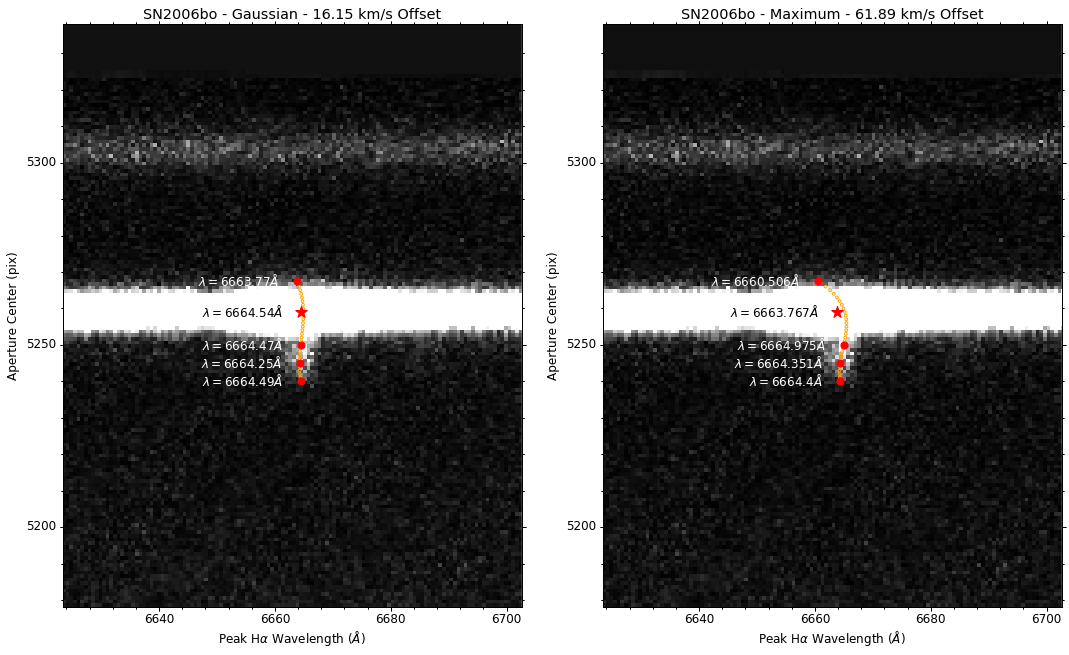

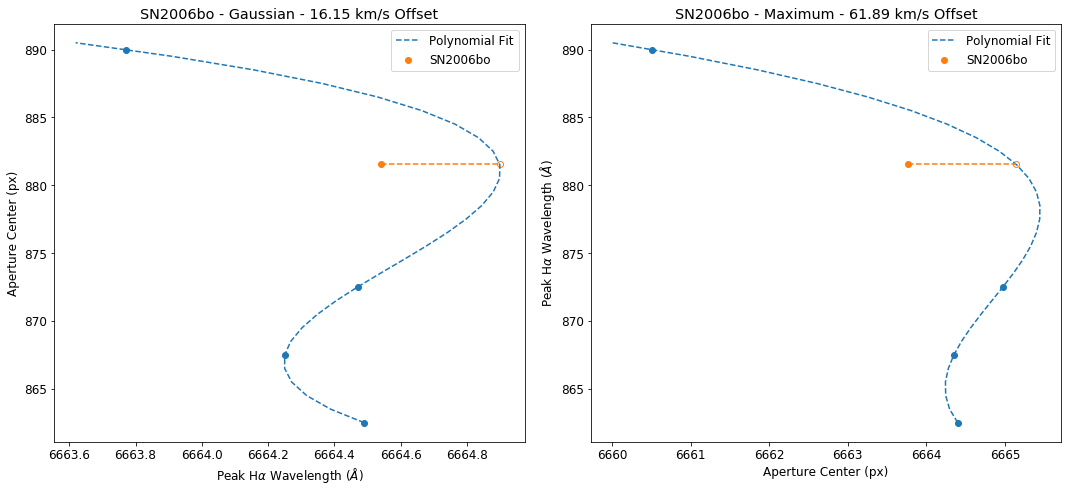

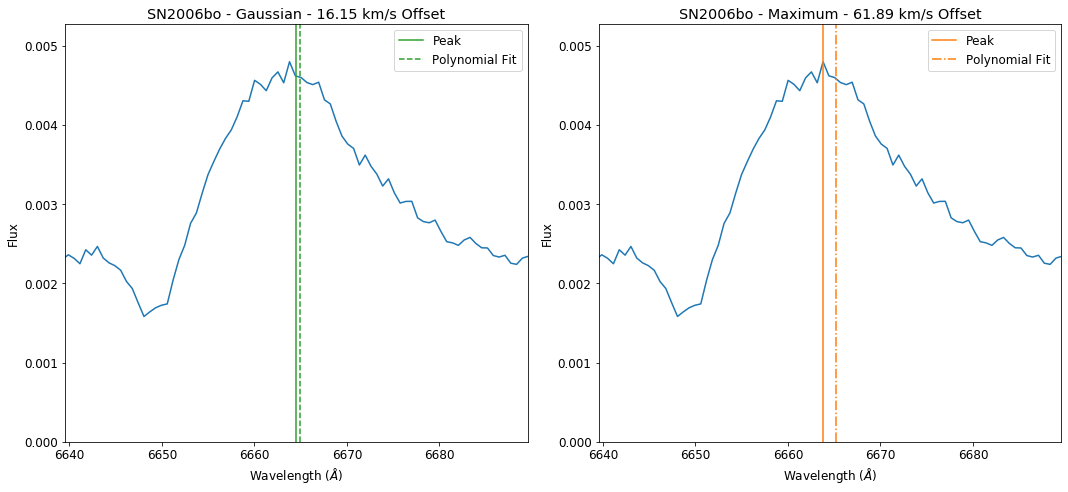

In [30]:
pltAll("SN2006bo",(6663,5258),4377.5,maxP=99.25)

INFO: Auto-setting vmin to -9.929e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.626e+01 [aplpy.core]


INFO: Auto-setting vmin to -8.853e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.065e+02 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


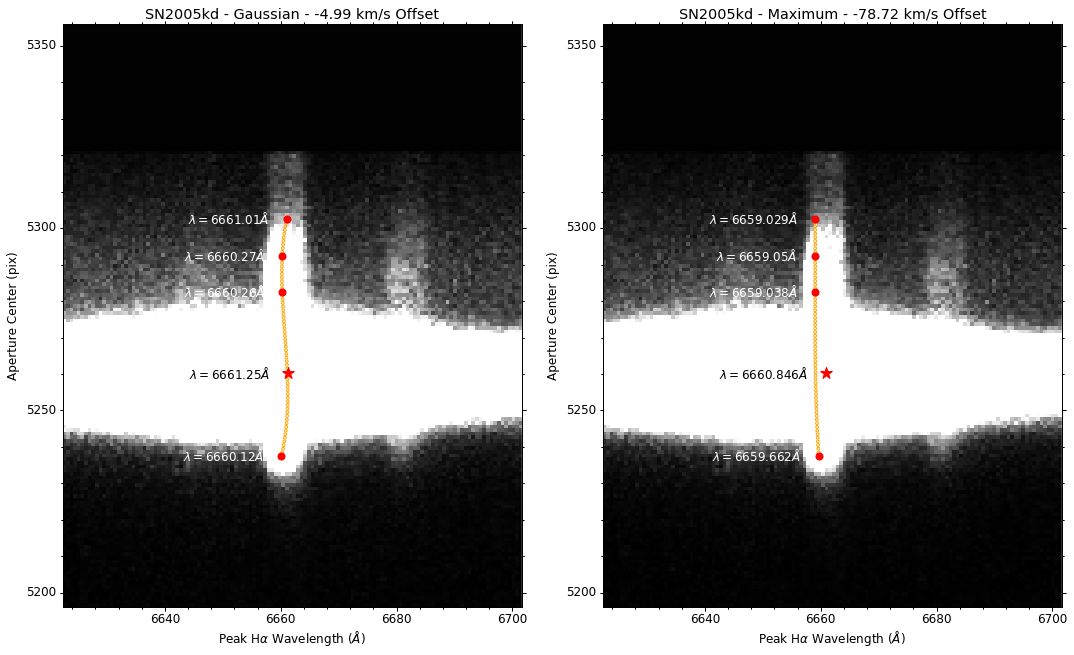

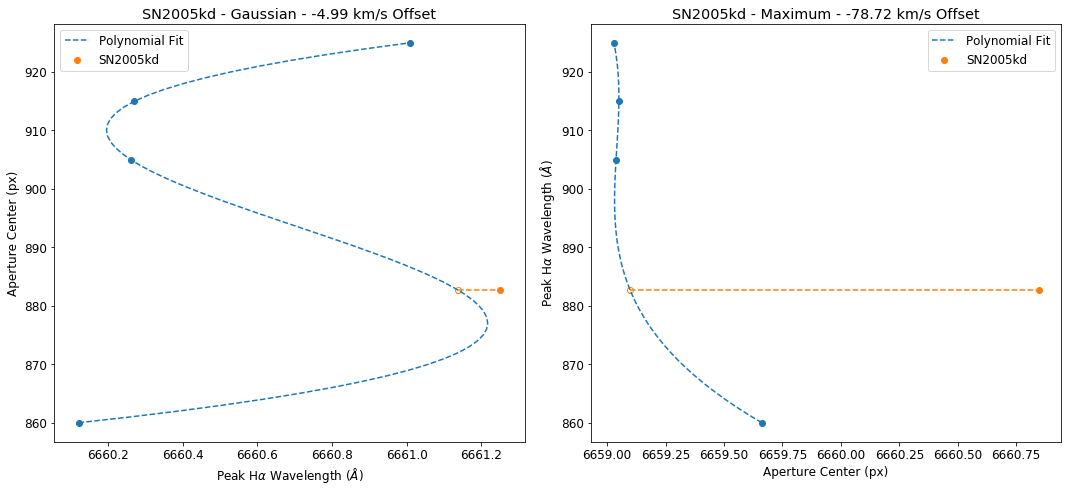

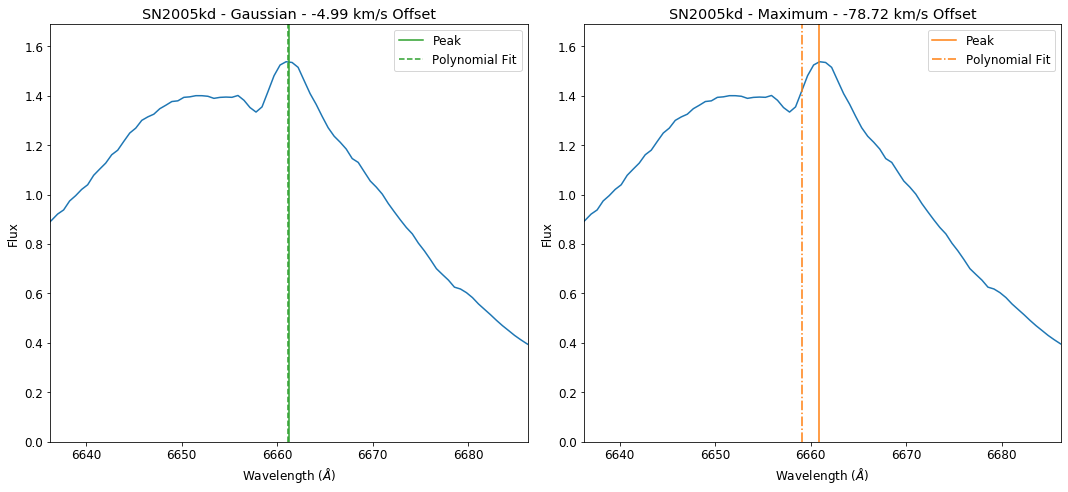

In [31]:
pltAll("SN2005kd",(6662,5276),4377.5,maxP=99.25)

INFO: Auto-setting vmin to -1.036e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.681e+01 [aplpy.core]


INFO: Auto-setting vmin to -9.405e+00 [aplpy.core]
INFO: Auto-setting vmax to  8.856e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


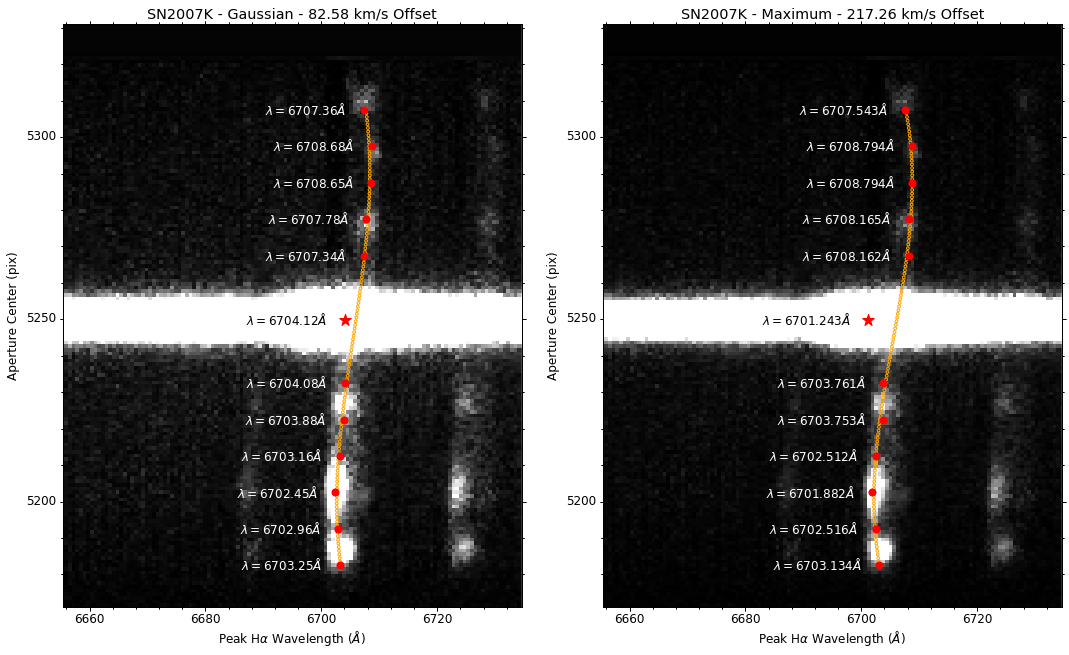

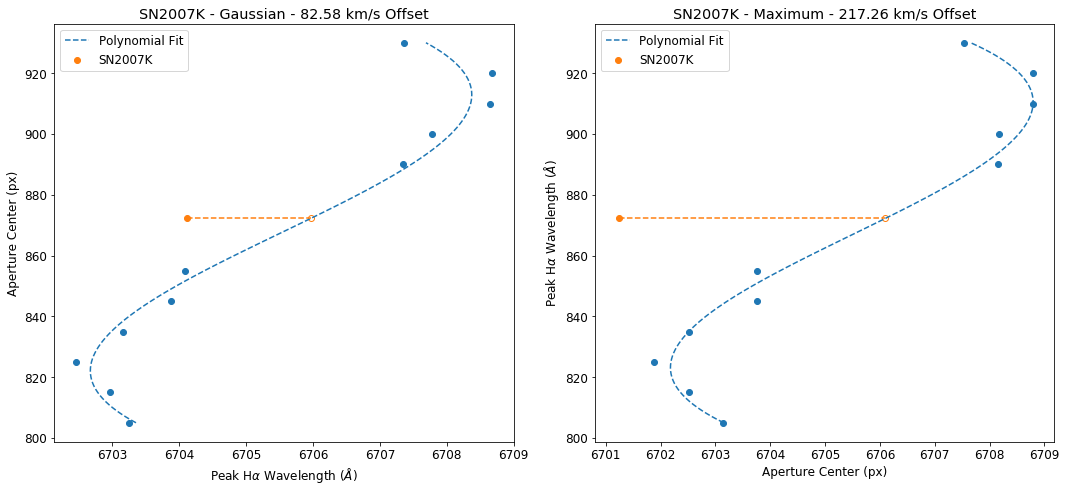

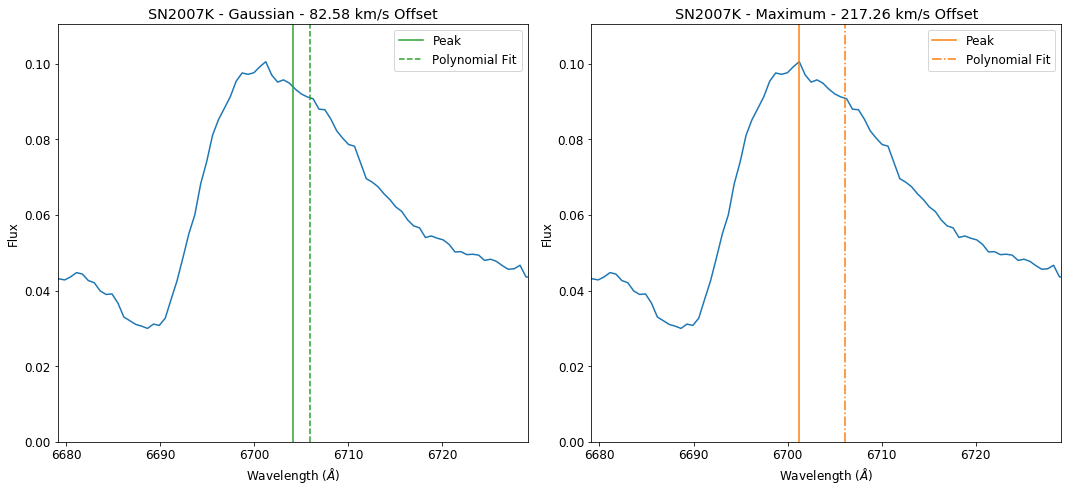

In [32]:
pltAll("SN2007K",(6695,5251),5177.5-800,winWidth=50)

INFO: Auto-setting vmin to -7.680e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.056e+01 [aplpy.core]


INFO: Auto-setting vmin to -8.298e+00 [aplpy.core]
INFO: Auto-setting vmax to  6.560e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


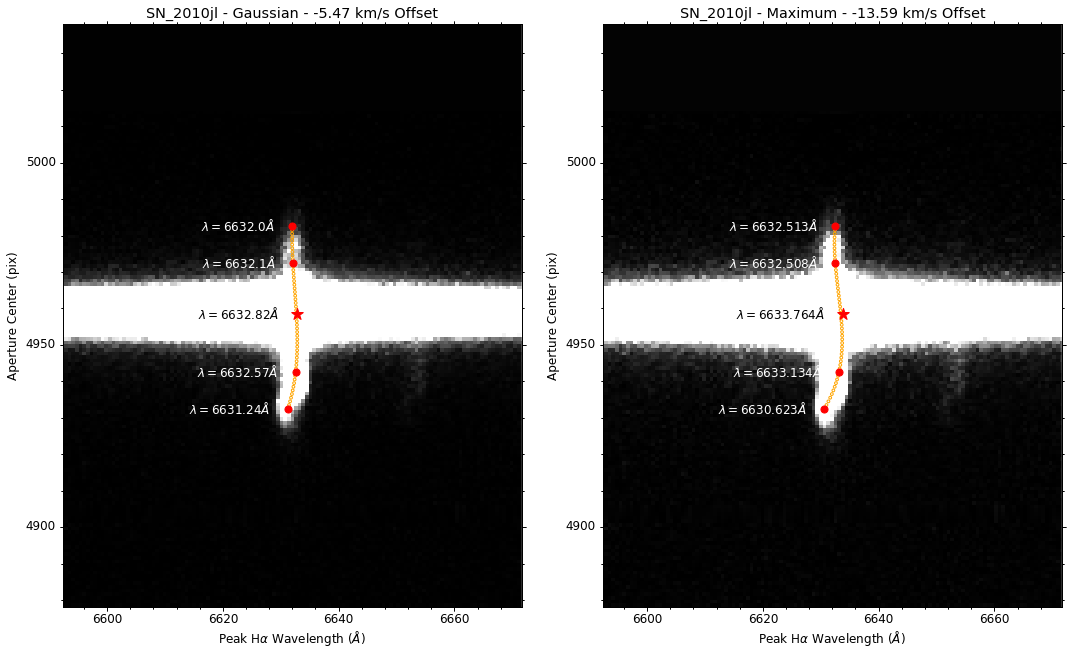

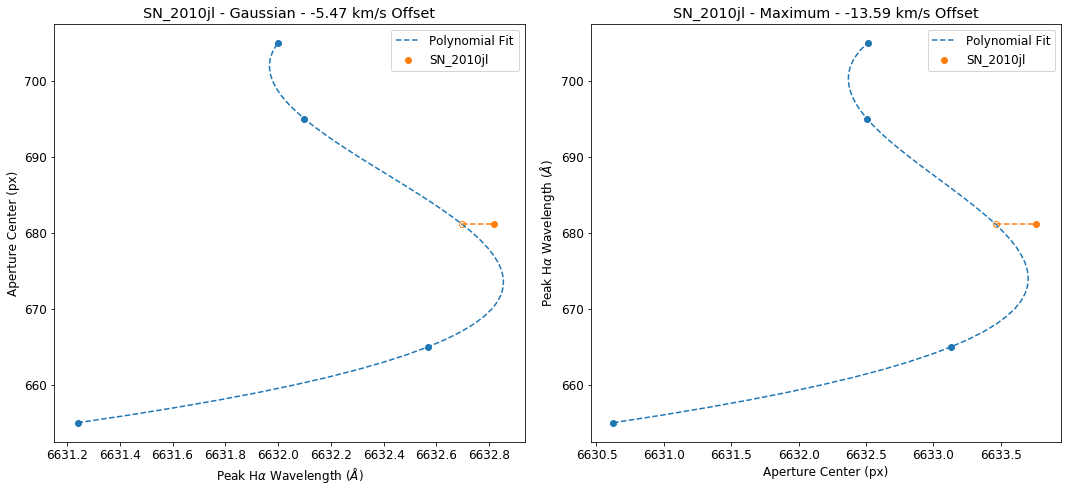

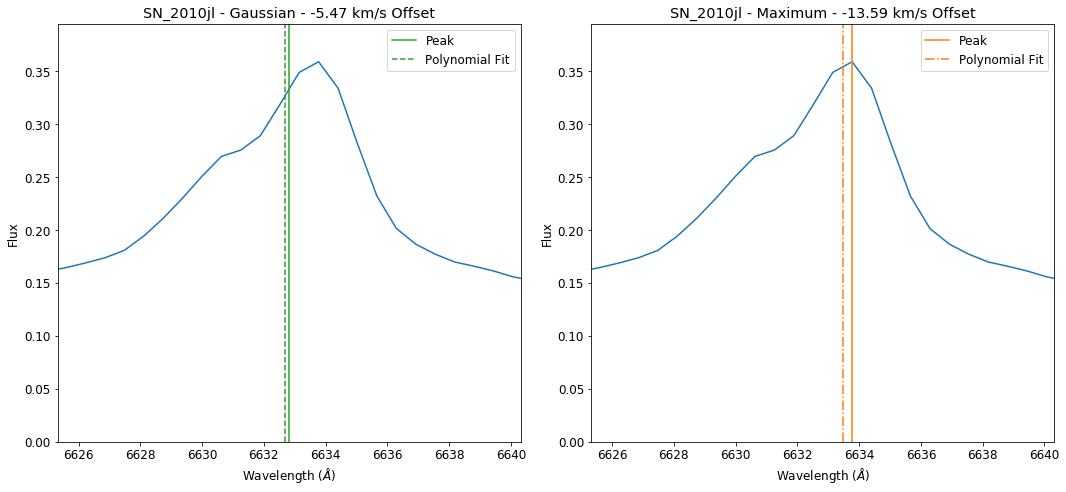

In [33]:
pltAll("SN_2010jl",(6632,4958),4277.5,maxP=99.2,winWidth=15)

INFO: Auto-setting vmin to -1.394e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.472e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.267e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.494e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


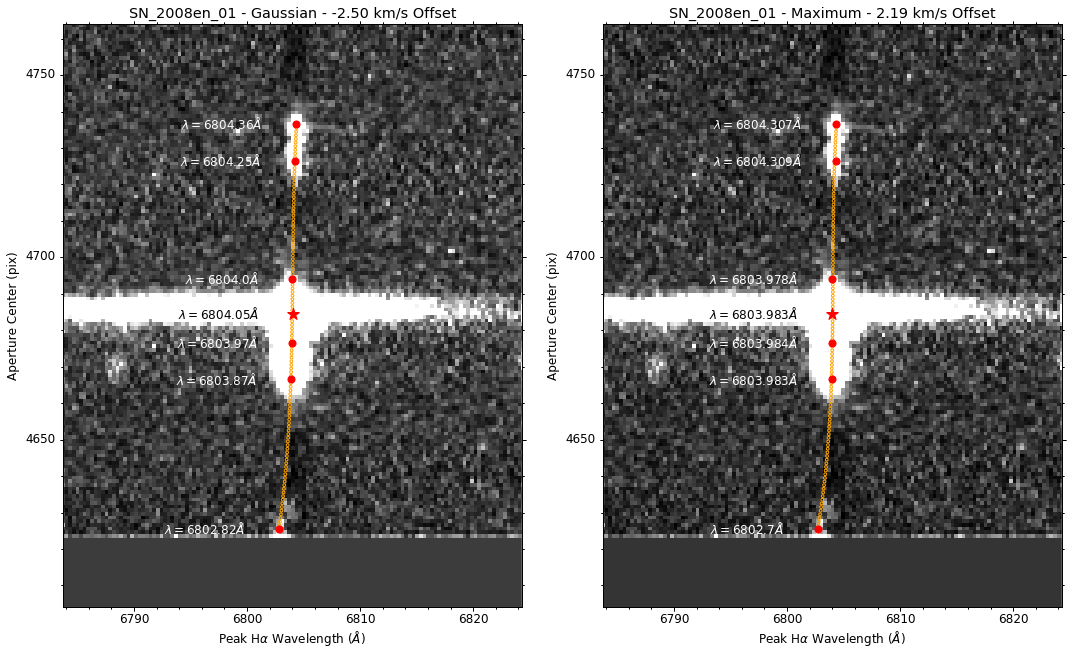

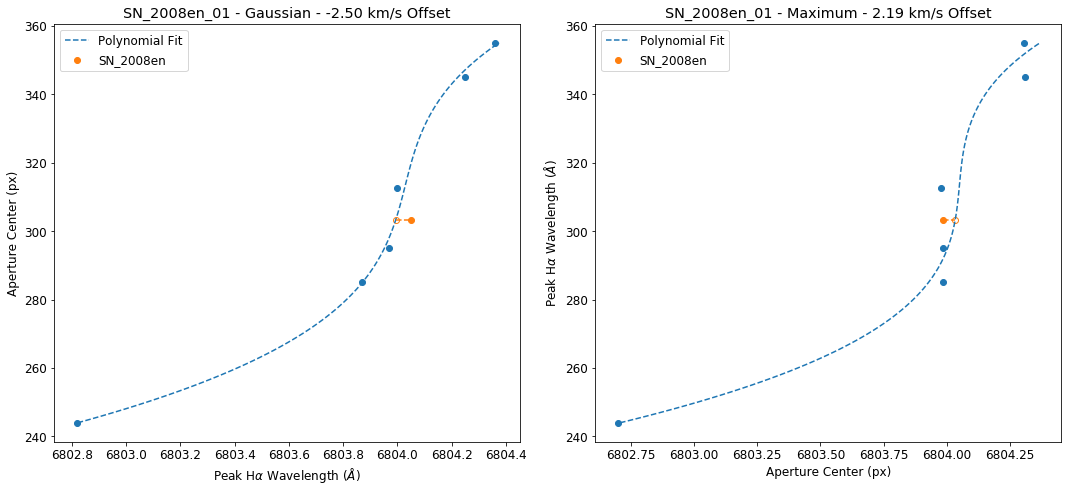

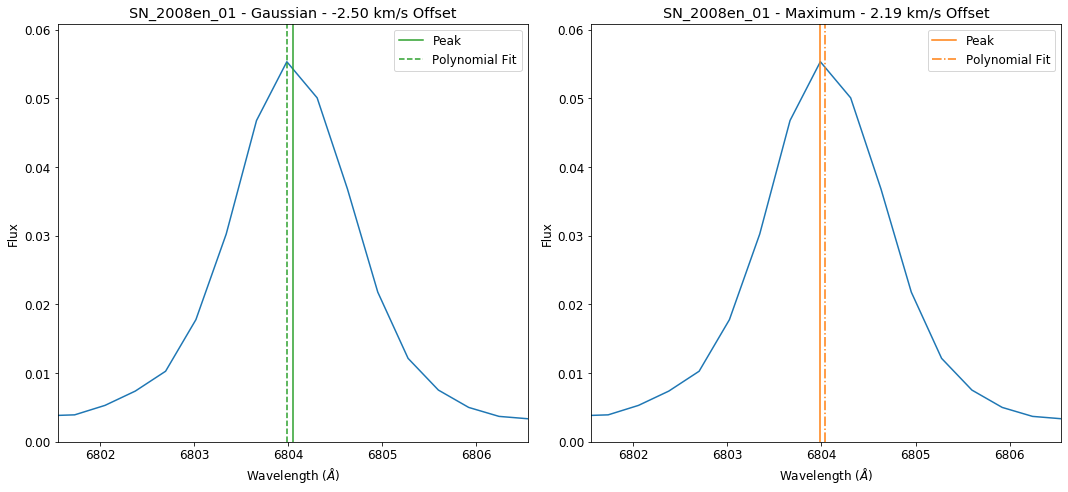

In [34]:
pltAll("SN_2008en",(6804,4684),4381.5,maxP=99.75,BR='R',num='1',multi=True,winWidth=5)

INFO: Auto-setting vmin to -1.333e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.499e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.521e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.696e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


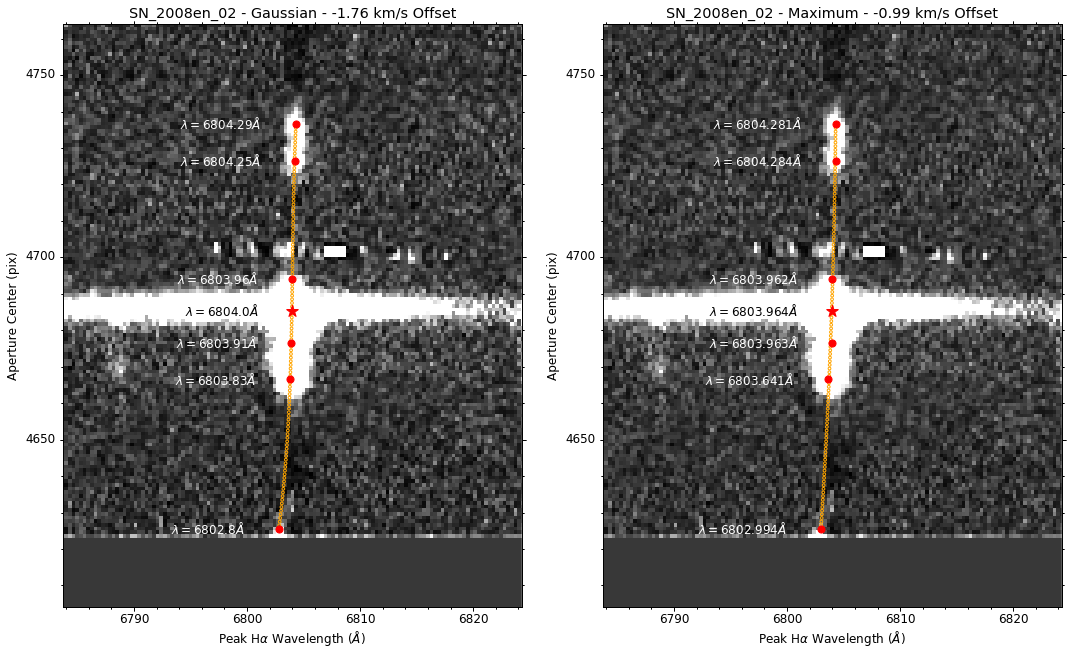

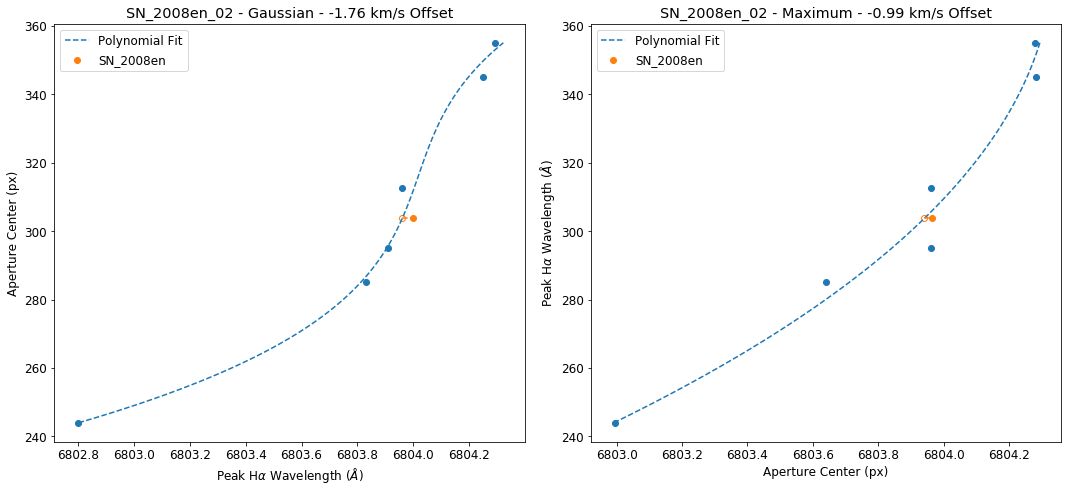

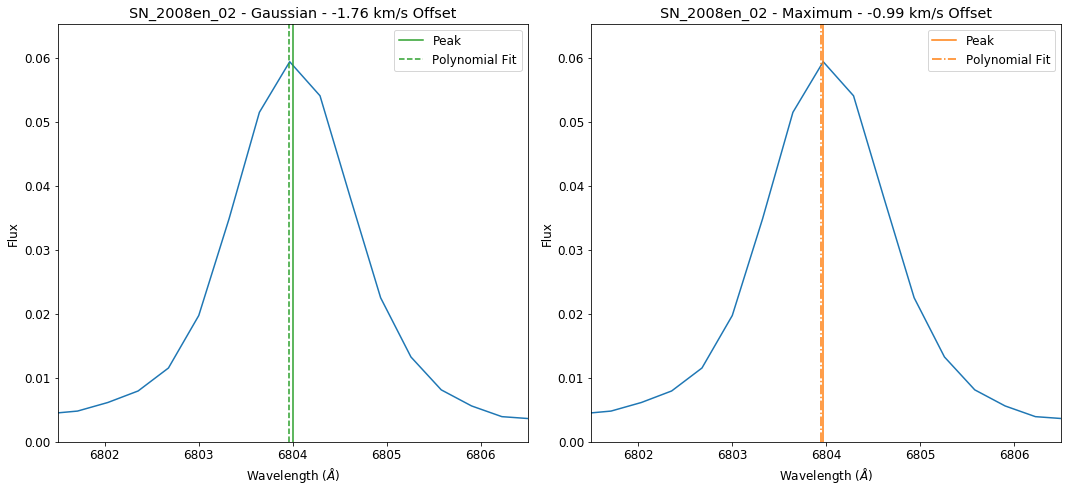

In [35]:
pltAll("SN_2008en",(6804,4684),4381.5,maxP=99.75,BR='R',num='2',multi=True,winWidth=5)

INFO: Auto-setting vmin to -1.359e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.196e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.324e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.274e+01 [aplpy.core]


/Users/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


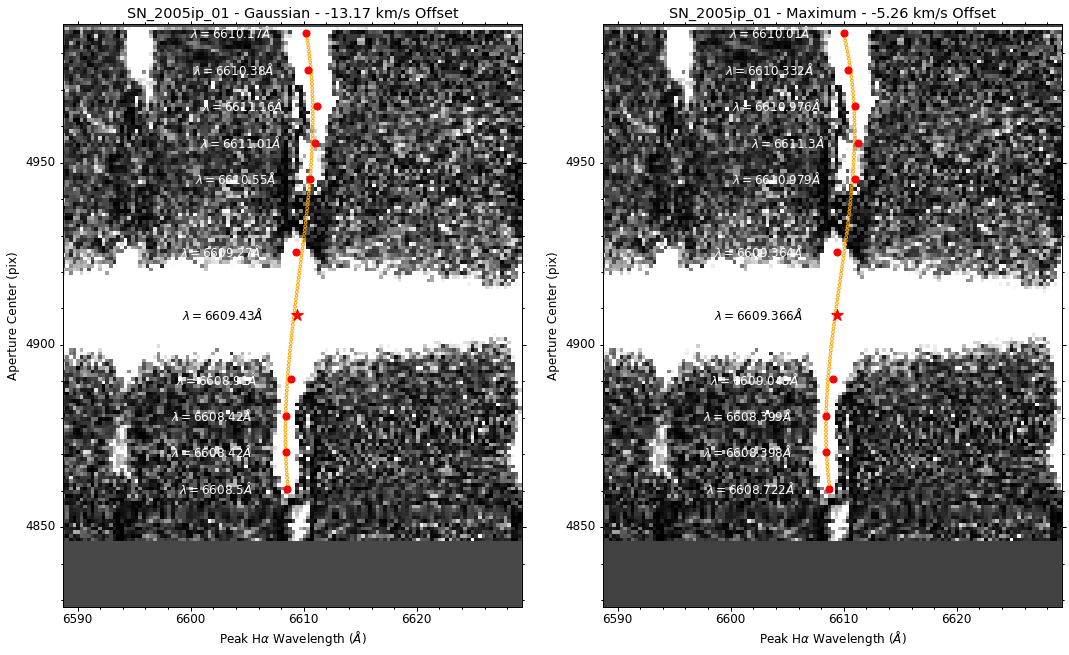

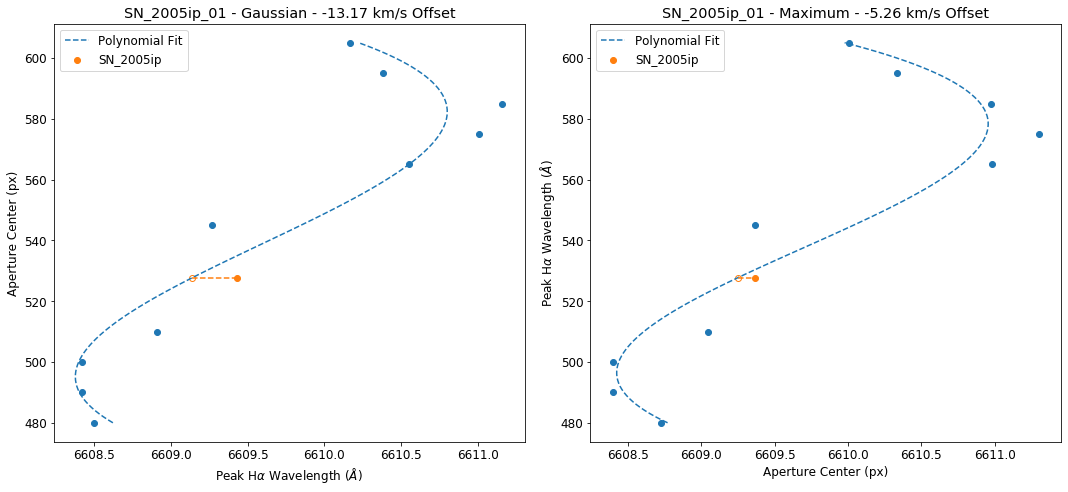

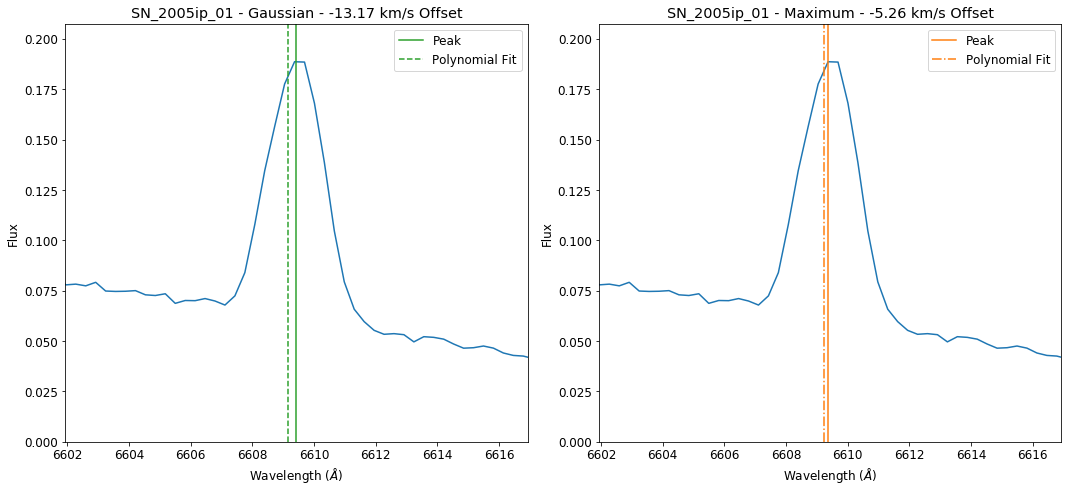

In [36]:
pltAll("SN_2005ip",(6609,4908),4380.5,BR='R',num='1',multi=True,winWidth=15)

INFO: Auto-setting vmin to -1.390e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.360e+01 [aplpy.core]


KeyboardInterrupt: 

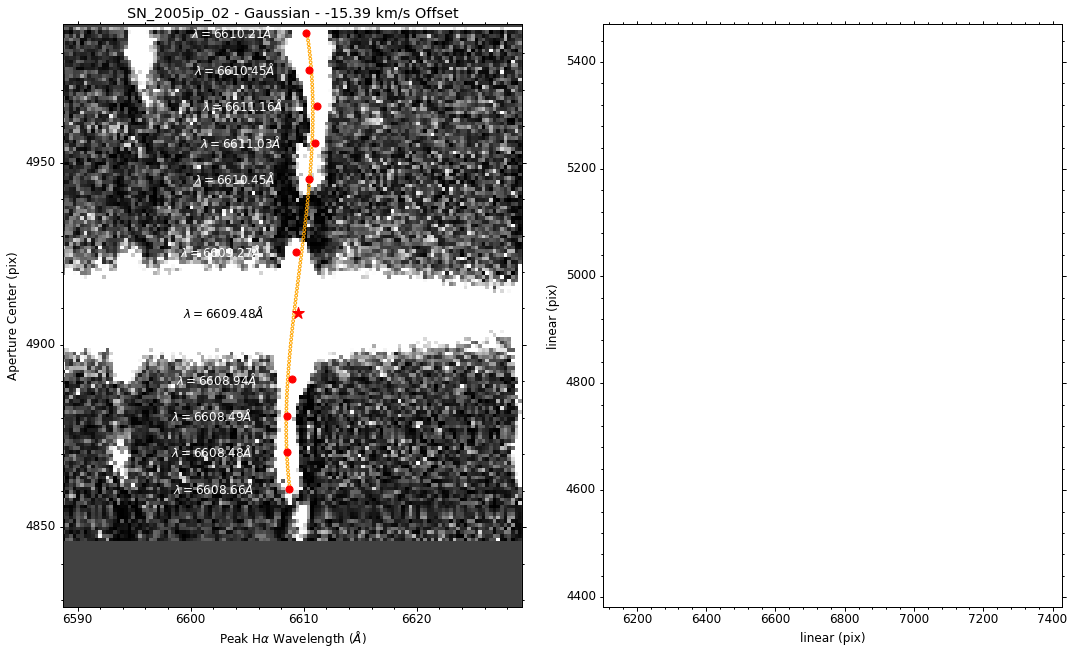

In [37]:
pltAll("SN_2005ip",(6609,4908),4380.5,BR='R',num='2',multi=True,winWidth=15)

In [ ]:
pltAll("SN_2013W",(6761,4913),4877.8-500.3,winWidth=20)

***

## Polynomial Fit

In [13]:
name = 'SN2007K'
dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))

In [14]:
galData = dataTable[:-1]
conData = dataTable[-1]

In [15]:
apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)

In [16]:
zG = np.polyfit(galData['Aperture Center'],galData['Peak (Gaussian)'],3)
zM = np.polyfit(galData['Aperture Center'],galData['Peak (Maximum)'],3)

In [17]:
gFit = np.poly1d(zG)
mFit = np.poly1d(zM)

In [18]:
fg,fm = genInterp(galData)

In [19]:
print('polyfit:\t',losVel(gFit,conData['Peak (Gaussian)'],conData['Aperture Center']))
print('interp:\t\t',losVel(fg,conData['Peak (Gaussian)'],conData['Aperture Center']))

polyfit:	 82.57801247669325
interp:		 66.26054129618313


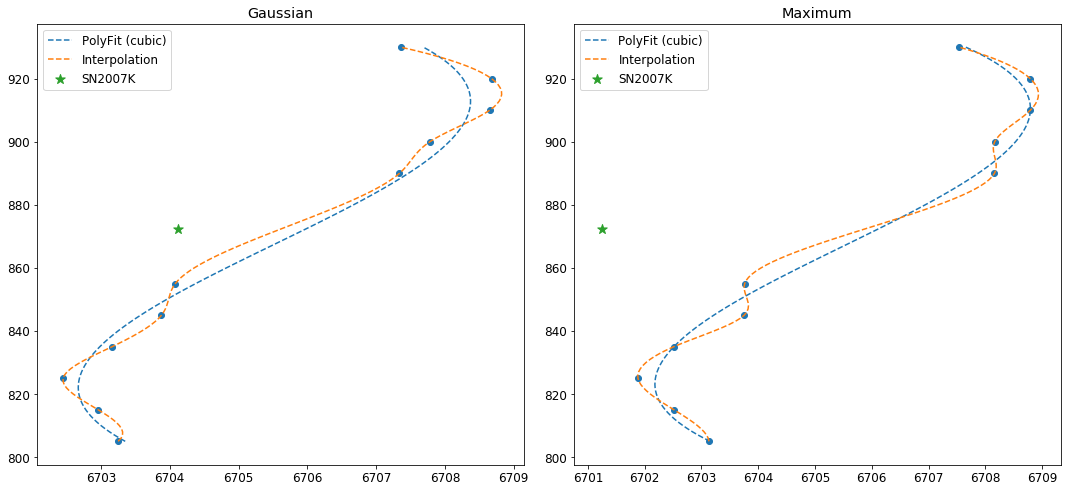

In [20]:
fig = plt.figure(figsize=(15,7))

fig.add_subplot(1,2,1)
plt.title('Gaussian')
plt.plot(gFit(apSpace),apSpace,ls='--',label='PolyFit (cubic)')
plt.plot(fg(apSpace),apSpace,ls='--',label='Interpolation')
plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'],label='')
plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],marker='*',c='C2',s=100,label=name)
# plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],gFit(conData['Aperture Center']))),
#         float(max(conData['Peak (Gaussian)'],gFit(conData['Aperture Center']))),50),
#         [conData['Aperture Center']]*50,ls='--',c='C0')
# plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),
#         float(max(conData['Peak (Gaussian)'],fg(conData['Aperture Center']))),50),
#         [conData['Aperture Center']]*50,ls='--',c='C1')
plt.legend()

fig.add_subplot(1,2,2)
plt.title('Maximum')
plt.plot(mFit(apSpace),apSpace,ls='--',label='PolyFit (cubic)')
plt.plot(fm(apSpace),apSpace,ls='--',label='Interpolation')
plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'],label='')
plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],marker='*',c='C2',s=100,label=name)
# plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],mFit(conData['Aperture Center']))),
#         float(max(conData['Peak (Maximum)'],mFit(conData['Aperture Center']))),50),
#         [conData['Aperture Center']]*50,ls='--',c='C0')
# plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),
#         float(max(conData['Peak (Maximum)'],fm(conData['Aperture Center']))),50),
#         [conData['Aperture Center']]*50,ls='--',c='C1')
plt.legend()

plt.tight_layout()
plt.show()

***

## Plotting all spectra

Probably have to do an ls and loop through all the files or something

then just run `pltSpec` for each one? maybe make a new function

In [21]:
!pwd

/Volumes/GoogleDrive/My Drive/Grad School/Summer-Research-2018


In [22]:
import os

In [23]:
next(os.walk('SN_Images'))[1]

['SN2006bo',
 'SN2005kd',
 'SN2007K',
 'SN_2010jl',
 'SN_2008en',
 'SN_2005ip',
 'SN_2013W']

In [24]:
next(os.walk('SN_Images'))[1]

['SN2006bo',
 'SN2005kd',
 'SN2007K',
 'SN_2010jl',
 'SN_2008en',
 'SN_2005ip',
 'SN_2013W']

In [25]:
SN2007K_apList = [(t[-11:-8]) for t in os.listdir('SN_Images/SN2007K/Gal_spec/') if t.endswith('.fits') if 'B' in t if '01' in t]

In [38]:
# Probably want info from the SN lines in this as well??? I'll add that later.

def pltGalSpec(name,ap,BR='B',num='1',multi=False,winWidth=50):
    from astropy.io import fits
    
    ap = str(ap)
    
    FITSfile = fits.open('SN_Images/%s/Gal_spec/s%s_0%s_%s_%s.ms.fits'%(name,name,num,BR,ap))
    head = FITSfile[0].header
    data = FITSfile[0].data
    
    x0 = head['CRVAL1']
    dx = head['CD1_1']
    xL = head['NAXIS1']
    
    if BR == 'B':
        maxF = max(data[-2000:])
    elif BR == 'R':
        maxF = max(data[:-2000])
    
    lamRange = np.arange(x0,dx*xL+x0,dx)[:xL]
    
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num+'_'+ap
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name+'_'+ap
        
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center']
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    fg, fm = genInterp(galData)
    pg, pm = genPoly(galData)
    
    fig = plt.figure(figsize=(15,7))
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian'%(tname))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    plt.ylim(0,maxF*1.1)
    
    plt.plot(lamRange,data)
# # #     plt.scatter(conData['Peak (Maximum)'],maxF,c='C1',label='Maximum Flux')
    plt.axvline(conData['Peak (Gaussian)'],c='C2',label='SN Peak')
# #     plt.axvline(fg(conData['Aperture Center']),ls='--',c='C2',label='Interpolated (Gaussian)')
    plt.axvline(pg(conData['Aperture Center']),ls='--',c='C2',label='SN Peak (Polynomial Fit)')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum'%(tname))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    plt.ylim(0,maxF*1.1)
    plt.plot(lamRange,data)
    plt.axvline(conData['Peak (Maximum)'],c='C1',label='SN Peak')
#     plt.axvline(fm(conData['Aperture Center']),ls='-.',c='C1',label='Interpolated (Maximum)')
    plt.axvline(pm(conData['Aperture Center']),ls='-.',c='C1',label='SN Peak (Polynomial Fit)')
    plt.legend()
    
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/Gal_spec/%s_0%s_%s_spec.png'%(name,name,num,ap))
    elif not multi:    
        plt.savefig('SN_Images/%s/Gal_spec/%s_%s_spec.png'%(name,name,ap))
    
    plt.show()


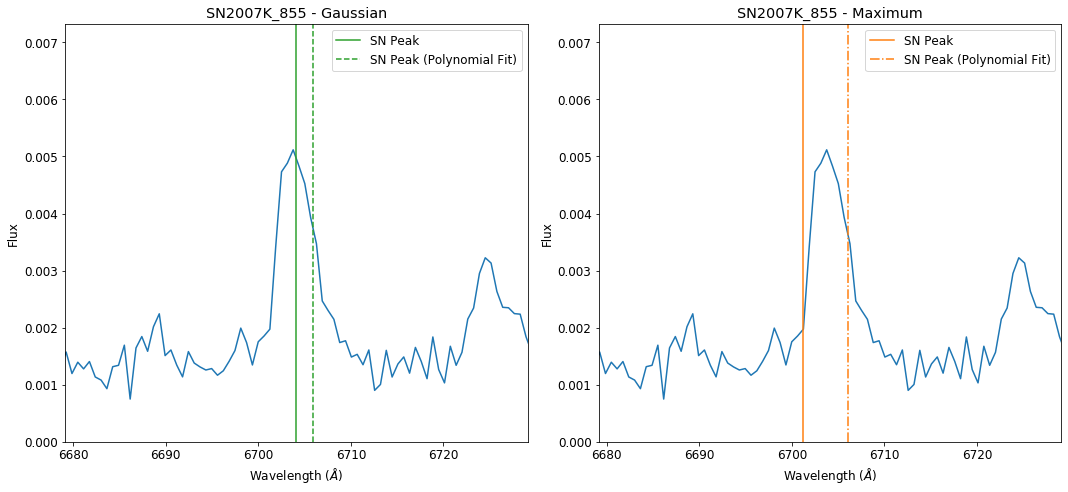

In [46]:
pltGalSpec('SN2007K',855)

In [68]:
# This isn't useful

def pltGalSpec2(name,BR='B',num='1',multi=False,winWidth=50):
    from astropy.io import fits
    
    apList = [(t[-13:-8]).replace('B_','') for t in os.listdir('SN_Images/%s/Gal_spec/'%(name)) if t.endswith('.fits') if BR in t if '0'+num in t]
#     apList.remove('c')
    print(apList)
    
    cm = mpl.cm.get_cmap(name='cool')
    currentColors = [cm(1.*i/len(apList)) for i in range(len(apList))]
    
    if multi:
        dataTable = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
        
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center']
    galData = dataTable[:-1]
    conData = dataTable[-1]
    
    fg, fm = genInterp(galData)
    pg, pm = genPoly(galData)
    
    fig = plt.figure(figsize=(15,7))
    plt.title('%s - Gaussian'%(tname))
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim(conData['Peak (Gaussian)'] - winWidth/2, conData['Peak (Gaussian)'] + winWidth/2)
    
    maxF = 0
    n = 0
    for ap in apList:
        FITSfile = fits.open('SN_Images/%s/Gal_spec/s%s_0%s_%s_%s.ms.fits'%(name,name,num,BR,ap))
        head = FITSfile[0].header
        data = FITSfile[0].data

        x0 = head['CRVAL1']
        dx = head['CD1_1']
        xL = head['NAXIS1']

        if BR == 'B':
            if max(data[-2000:]) >= maxF:
                maxF = max(data[-2000:])
        elif BR == 'R':
            if max(data[:-2000]) >= maxF:
                maxF = max(data[:-2000])

        lamRange = np.arange(x0,dx*xL+x0,dx)[:xL]

        plt.ylim(0,0.01*n + maxF*1.1)

        plt.plot(lamRange,data+.01*n,label=ap,color=currentColors[n])
        
        n += 1
    
    plt.axvline(conData['Peak (Gaussian)'],c='g',label='SN Peak')
    plt.axvline(pg(conData['Aperture Center']),ls='--',c='g',label='SN Peak (Polynomial Fit)')
    plt.legend()
    
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s/%s_0%s_galspec.png'%(name,name,num))
    elif not multi:    
        plt.savefig('SN_Images/%s/%s_galspec.png'%(name,name))
    
    plt.show()


In [72]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ls: .: No such file or directory


In [73]:
pltGalSpec2('SN2007K')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mike/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-73-ba13a81ea4a5>", line 1, in <module>
    pltGalSpec2('SN2007K')
  File "<ipython-input-68-3c62c0a155fe>", line 6, in pltGalSpec2
    apList = [(t[-13:-8]).replace('B_','') for t in os.listdir('SN_Images/%s/Gal_spec/'%(name)) if t.endswith('.fits') if BR in t if '0'+num in t]
FileNotFoundError: [Errno 2] No such file or directory: 'SN_Images/SN2007K/Gal_spec/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/mike/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occur

FileNotFoundError: [Errno 2] No such file or directory: 'SN_Images/SN2007K/Gal_spec/'

## Plotting NII Lines

In [17]:
def subpltFITSNII(fig,name,centerCoord,offset,galData,galDataH,conDataH,kind,maxP,w,h,multi,sub=1,BR='B',num='1'):
    filepath = 'SN_Images/%s_NII/%s_0%s_%s.fits'%(name,name,num,BR)
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center']),1)
    apSpaceH = np.arange(min(galDataH['Aperture Center']),max(galDataH['Aperture Center']),1)
    
    if multi:
        tname=name+"_0"+num
    elif not multi:
        tname=name
    
    if sub == 1:
        subCoords = [0.05,0.05,0.425,0.9]
        titleType = 'Gaussian'
#         f = interp1d(galData['Aperture Center'],galData['Peak (Gaussian)'],kind=kind)
        f = genPoly(galData)[0]
        fArr = np.vstack((f(apSpace),apSpace+offset))
        fH = genPoly(galDataH)[0]
        fArrH = np.vstack((fH(apSpaceH),apSpaceH+offset))
        conLam = 'Peak (Gaussian)'
    elif sub == 2:
        subCoords = [0.55,0.05,0.425,0.9]
        titleType = 'Maximum'
#         f = interp1d(galData['Aperture Center'],galData['Peak (Maximum)'],kind=kind)
        f = genPoly(galData)[1]
        fArr = np.vstack((f(apSpace),apSpace+offset))
        fH = genPoly(galDataH)[1]
        fArrH = np.vstack((fH(apSpaceH),apSpaceH+offset))
        conLam = 'Peak (Maximum)'
    
    subplt = aplpy.FITSFigure(filepath,figure=fig,subplot=subCoords)
    subplt.recenter(centerCoord[0],centerCoord[1],width=w,height=h)
    subplt.show_grayscale(stretch='power',pmax=maxP)
    subplt.set_title('%s - %s'%(tname,titleType))
    subplt.axis_labels.set_xtext(r'Peak H$\alpha$ Wavelength ($\AA$)')
    subplt.axis_labels.set_ytext('Aperture Center (pix)')
    
    subplt.show_markers(fArr[0,:],fArr[1,:],marker='.',edgecolor='orange')
    
    for line in galData:
        addPeak(line['Aperture Center'],line[conLam],subplt,offset)
    
#     addPeak(conData['Aperture Center'],conData[conLam],subplt,offset,col='k',fontcol='k')
    
    subplt.show_markers(galData[conLam],galData['Adjusted Aperture'],marker='o',s=50,edgecolor=None,facecolor='r')
#     subplt.show_markers(conData[conLam],conData['Adjusted Aperture'],marker='*',s=150,edgecolor=None,facecolor='r')
    
    
    for line in galDataH:
        addPeak(line['Aperture Center'],line[conLam],subplt,offset)
    
    addPeak(conDataH['Aperture Center'],conDataH[conLam],subplt,offset,col='k',fontcol='k')
    
    subplt.show_markers(fArrH[0,:],fArrH[1,:],marker='.',edgecolor='orange')
    
    subplt.show_markers(galDataH[conLam],galDataH['Adjusted Aperture'],marker='o',s=50,edgecolor=None,facecolor='r')
    subplt.show_markers(conDataH[conLam],conDataH['Adjusted Aperture'],marker='*',s=150,edgecolor=None,facecolor='r')
    
    
    return



def pltFITSNII(name,centerCoord,offset,maxP=99,w=25,h=160,BR='B',num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s_NII/%s_0%s.csv'%(name,name,num))

    elif not multi:
        dataTable = ascii.read('SN_Images/%s_NII/%s.csv'%(name,name))

    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable#[:-1]
#     conData = dataTable[-1]
    
    if len(galData) > 3:
        kind = 'cubic'
    else:
        kind = 'quadratic'
    
    fig = plt.figure(figsize=(15,9))
    
    
    
    
    if multi:
        dataTableH = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))

    elif not multi:
        dataTableH = ascii.read('SN_Images/%s/%s.csv'%(name,name))

    dataTableH['Adjusted Aperture'] = dataTableH['Aperture Center'] + offset
    
    galDataH = dataTableH[:-1]
    conDataH = dataTableH[-1]
    
#     subpltFITS(fig,name,centerCoord,offset,galDataH,conDataH,kind,maxP,w,h,multi,sub=1,BR=BR,num=num)
#     subpltFITS(fig,name,centerCoord,offset,galDataH,conDataH,kind,maxP,w,h,multi,sub=2,BR=BR,num=num)
    
    
    subpltFITSNII(fig,name,centerCoord,offset,galData,galDataH,conDataH,kind,maxP,w,h,multi,sub=1,BR=BR,num=num)
    subpltFITSNII(fig,name,centerCoord,offset,galData,galDataH,conDataH,kind,maxP,w,h,multi,sub=2,BR=BR,num=num)
    
    if multi:
        fig.savefig('SN_Images/%s_NII/%s_0%s.png'%(name,name,num))
    elif not multi:    
        fig.savefig('SN_Images/%s_NII/%s.png'%(name,name))
    fig.show()
    return

In [78]:
def pltPolyNII(name,offset,num='1',multi=False):
    if multi:
        dataTable = ascii.read('SN_Images/%s_NII/%s_0%s.csv'%(name,name,num))
        dataTableH = ascii.read('SN_Images/%s/%s_0%s.csv'%(name,name,num))
        tname = name+"_0"+num
    elif not multi:
        dataTable = ascii.read('SN_Images/%s_NII/%s.csv'%(name,name))
        dataTableH = ascii.read('SN_Images/%s/%s.csv'%(name,name))
        tname=name
    dataTable['Adjusted Aperture'] = dataTable['Aperture Center'] + offset
    
    galData = dataTable
    galDataH = dataTableH[:-1]
    conDataH = dataTableH[-1]
    
    apSpace = np.arange(min(galData['Aperture Center']),max(galData['Aperture Center'])+1,1)
    apSpaceH = np.arange(min(galDataH['Aperture Center']),max(galDataH['Aperture Center'])+1,1)
    
    pg, pm = genPoly(galData)
    pgH, pmH = genPoly(galDataH)
    print("Gaussian, HAl:\t",pgH)
    print("Gaussian, NII:\t",pg)
    print("Maximum, HAl:\t",pmH)
    print("Maximum, NII:\t",pm)
    
    fig = plt.figure(figsize=(15,7))
    
    fig.add_subplot(1,2,1)
    plt.title('%s - Gaussian'%(tname))
    plt.ylabel('Aperture Center (px)')
    plt.xlabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Gaussian)'],galData['Aperture Center'])
    plt.plot(pg(apSpace),apSpace,'--',label='NII: ' + polystr(pg))
    plt.scatter(galDataH['Peak (Gaussian)'],galDataH['Aperture Center'])
    plt.plot(pgH(apSpaceH),apSpaceH,'--',label='HA: ' + polystr(pgH))
#     plt.scatter(pg(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
#     plt.scatter(conData['Peak (Gaussian)'],conData['Aperture Center'],label=name)
#     plt.plot(np.linspace(float(min(conData['Peak (Gaussian)'],pg(conData['Aperture Center']))),
#                 float(max(conData['Peak (Gaussian)'],pg(conData['Aperture Center']))),50),
#                 [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    fig.add_subplot(1,2,2)
    plt.title('%s - Maximum'%(tname))
    plt.xlabel('Aperture Center (px)')
    plt.ylabel(r'Peak H$\alpha$ Wavelength ($\AA$)')
    
    plt.scatter(galData['Peak (Maximum)'],galData['Aperture Center'])
    plt.plot(pm(apSpace),apSpace,'--',label='NII: ' + polystr(pm))
    plt.scatter(galDataH['Peak (Maximum)'],galDataH['Aperture Center'])
    plt.plot(pmH(apSpaceH),apSpaceH,'--',label='HA: ' + polystr(pmH))
#     plt.scatter(conData['Peak (Maximum)'],conData['Aperture Center'],label=name)
#     plt.scatter(pm(conData['Aperture Center']),conData['Aperture Center'],edgecolor='C1',c='w')
#     plt.plot(np.linspace(float(min(conData['Peak (Maximum)'],pm(conData['Aperture Center']))),
#                 float(max(conData['Peak (Maximum)'],pm(conData['Aperture Center']))),50),
#                 [conData['Aperture Center']]*50,ls='--',c='C1')
    plt.legend()
    
    plt.tight_layout()
    
    if multi:
        plt.savefig('SN_Images/%s_NII/%s_0%s_poly.png'%(name,name,num))
    elif not multi:
        plt.savefig('SN_Images/%s_NII/%s_poly.png'%(name,name))

## NII Plots

Gaussian, HAl:	             3           2
-1.154e-05 x + 0.03002 x - 25.96 x + 1.416e+04
Gaussian, NII:	           3           2
-1.4e-05 x + 0.03632 x - 31.32 x + 1.57e+04
Maximum, HAl:	            3           2
-1.44e-05 x + 0.03739 x - 32.26 x + 1.595e+04
Maximum, NII:	             3           2
-1.974e-05 x + 0.05144 x - 44.58 x + 1.958e+04


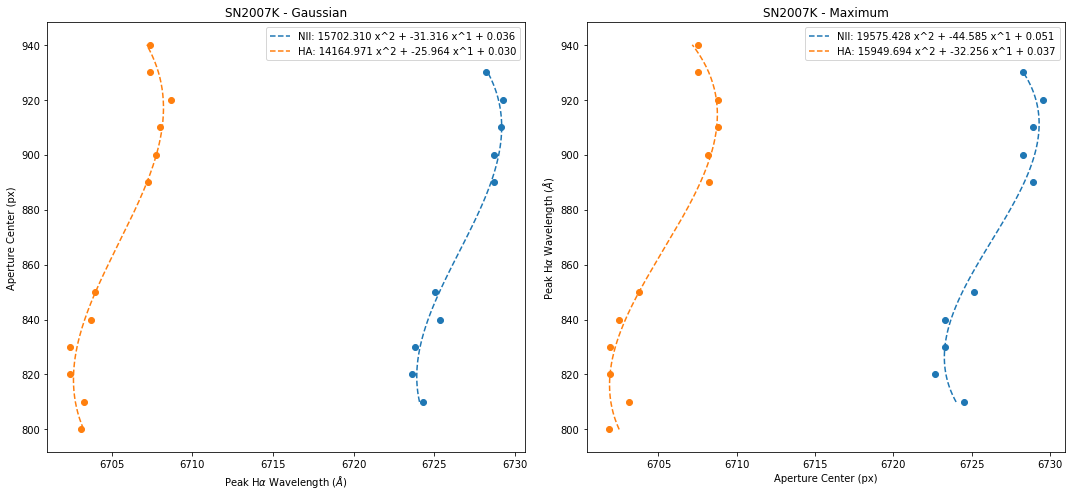

In [79]:
pltPolyNII('SN2007K',5177.5-800)

INFO: Auto-setting vmin to -9.033e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.554e+01 [aplpy.core]


INFO: Auto-setting vmin to -9.642e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.466e+01 [aplpy.core]


/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


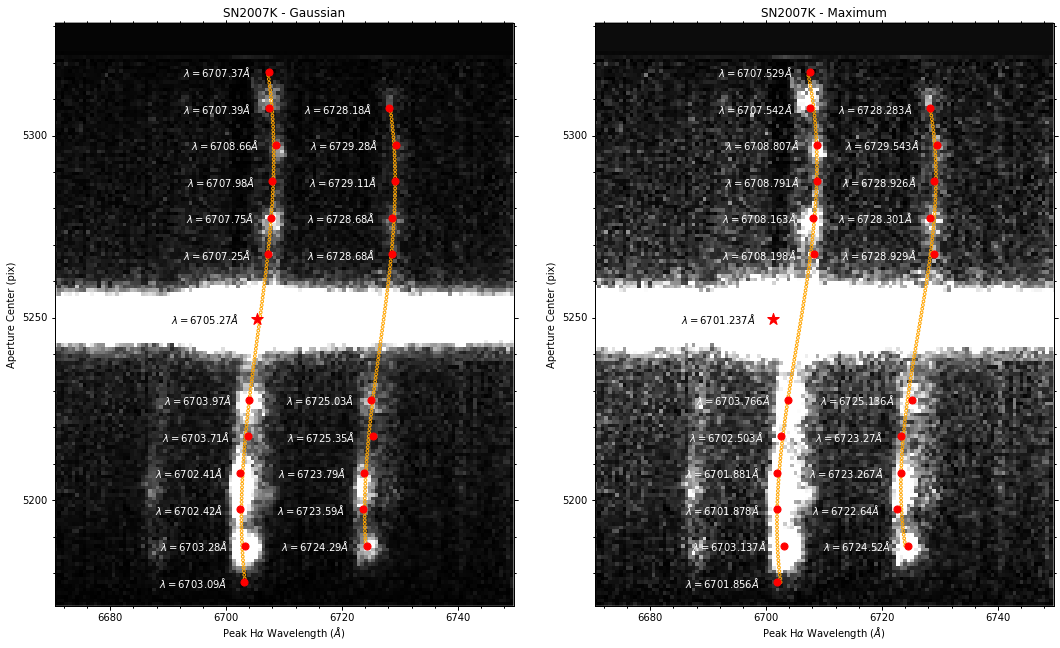

In [80]:
pltFITSNII('SN2007K',(6710,5251),5177.5-800)

INFO: Auto-setting vmin to -1.371e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.247e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.318e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.208e+01 [aplpy.core]


/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


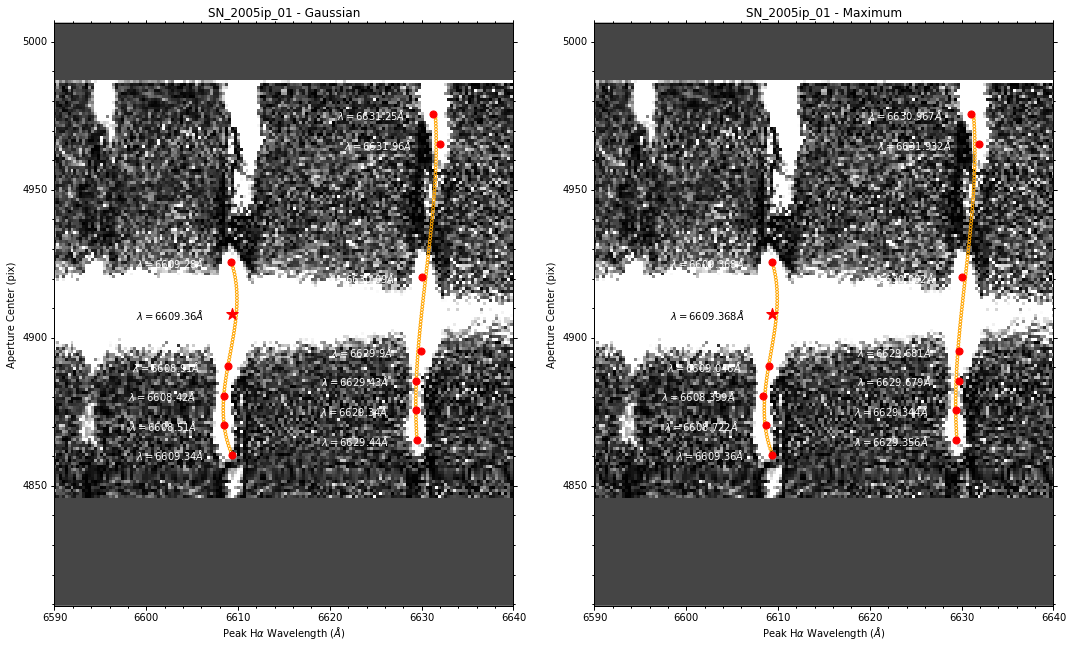

In [84]:
pltFITSNII('SN_2005ip',(6615,4908),4380.5,BR='R',num='1',multi=True,w=50)

Gaussian, HAl:	             3           2
-5.744e-05 x + 0.08857 x - 45.46 x + 1.438e+04
Gaussian, NII:	             3           2
-6.461e-06 x + 0.01048 x - 5.633 x + 7632
Maximum, HAl:	             3           2
-5.347e-05 x + 0.08246 x - 42.33 x + 1.384e+04
Maximum, NII:	             3           2
-6.637e-06 x + 0.01075 x - 5.765 x + 7655


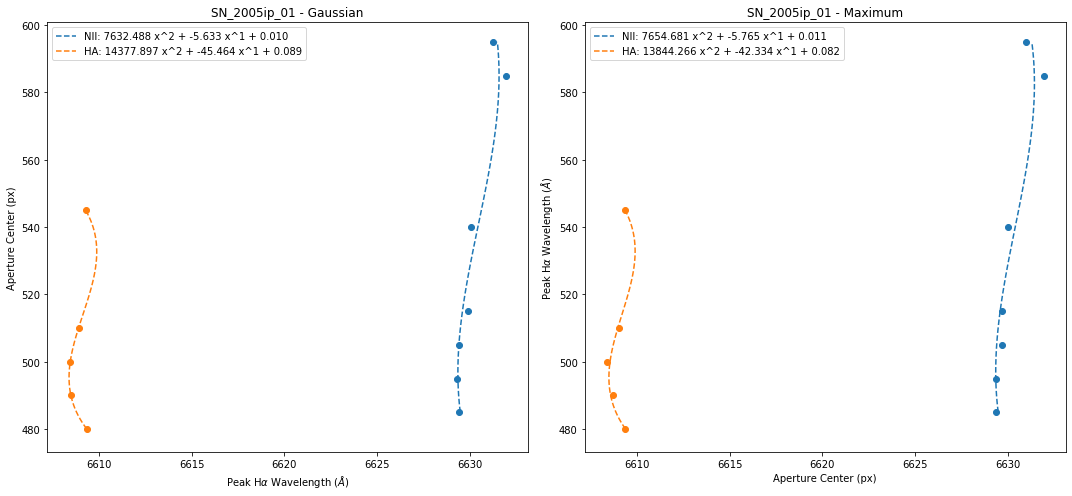

In [85]:
pltPolyNII('SN_2005ip',4380.5,num='1',multi=True)

INFO: Auto-setting vmin to -1.429e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.334e+01 [aplpy.core]


INFO: Auto-setting vmin to -1.404e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.242e+01 [aplpy.core]


/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


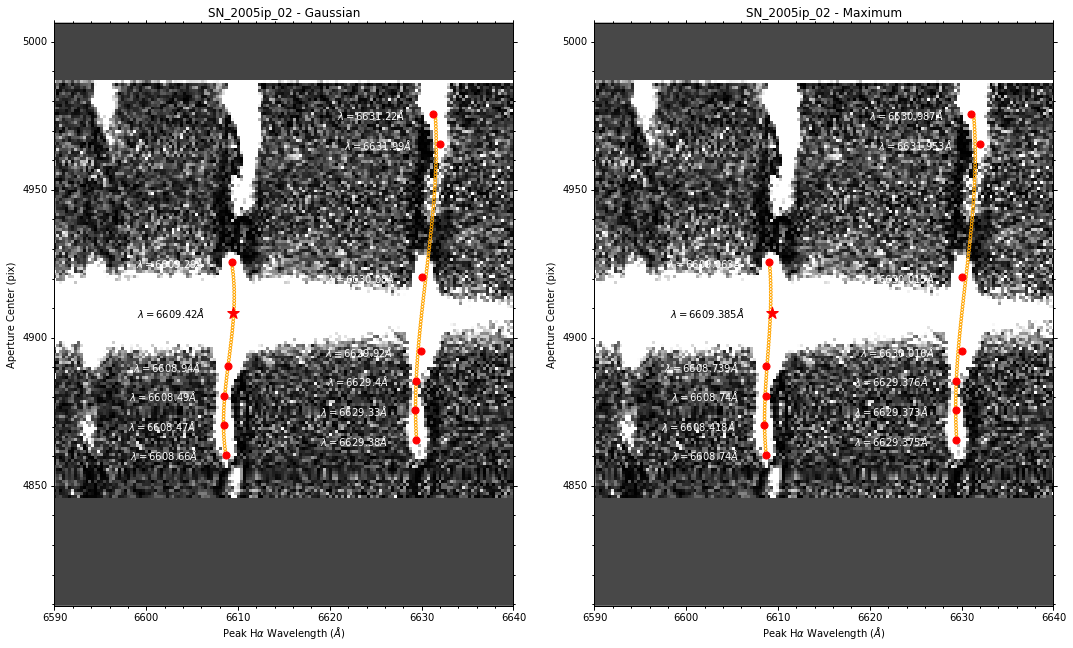

In [86]:
pltFITSNII('SN_2005ip',(6615,4908),4380.5,BR='R',num='2',multi=True,w=50)

Gaussian, HAl:	             3           2
-2.986e-05 x + 0.04588 x - 23.46 x + 1.06e+04
Gaussian, NII:	             3           2
-6.469e-06 x + 0.01048 x - 5.623 x + 7629
Maximum, HAl:	             3           2
-1.738e-05 x + 0.02674 x - 13.69 x + 8942
Maximum, NII:	             3           2
-6.802e-06 x + 0.01099 x - 5.882 x + 7673


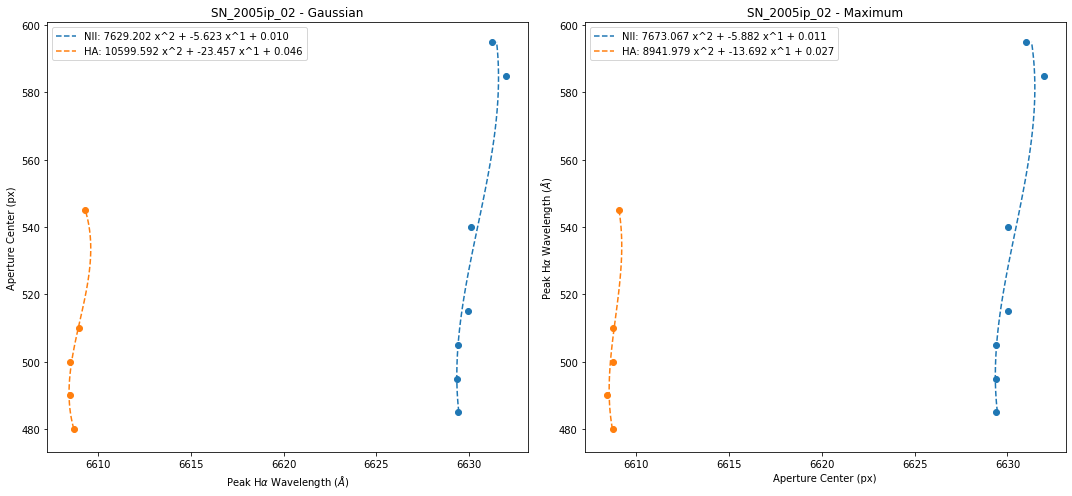

In [87]:
pltPolyNII('SN_2005ip',4380.5,num='2',multi=True)